In [1]:
%matplotlib notebook
import cmath
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from indra.common import Circle, Line
from indra.mobius import MobiusTransformation as Mobius
from indra.plotting.tiles import plot_tiles
from indra.plotting.limit import plot_limit_set
from indra.recipes import kissing_schottky

In [8]:
# Apollonian gasket generators
a = Mobius(1, 0, -2j, 1)
b = Mobius(1-1j, 1, 1, 1+1j)
A = a.inv()
B = b.inv()

gens = [a, b, A, B]

In [4]:
# Figure out what C_b is from tangency points
z1 = complex(1, 0)
z2 = complex(0, -1)
z3 = complex(0.2, -0.4)

w = z3 - z1
w /= z2 - z1
cen = (z1 - z2) * (w - abs(w) ** 2) / 2j / w.imag - z1
rad = abs(cen + z1)

In [5]:
-cen, rad

((0.9999999999999999-0.9999999999999999j), 0.9999999999999999)

In [6]:
C_a = Line(np.pi/2, 0)
C_A = A(C_a)
C_b = Circle(complex(1, -1), 1)
C_B = Circle(complex(-1, -1), 1)

circs = [C_a, C_b, C_A, C_B]

<IPython.core.display.Javascript object>


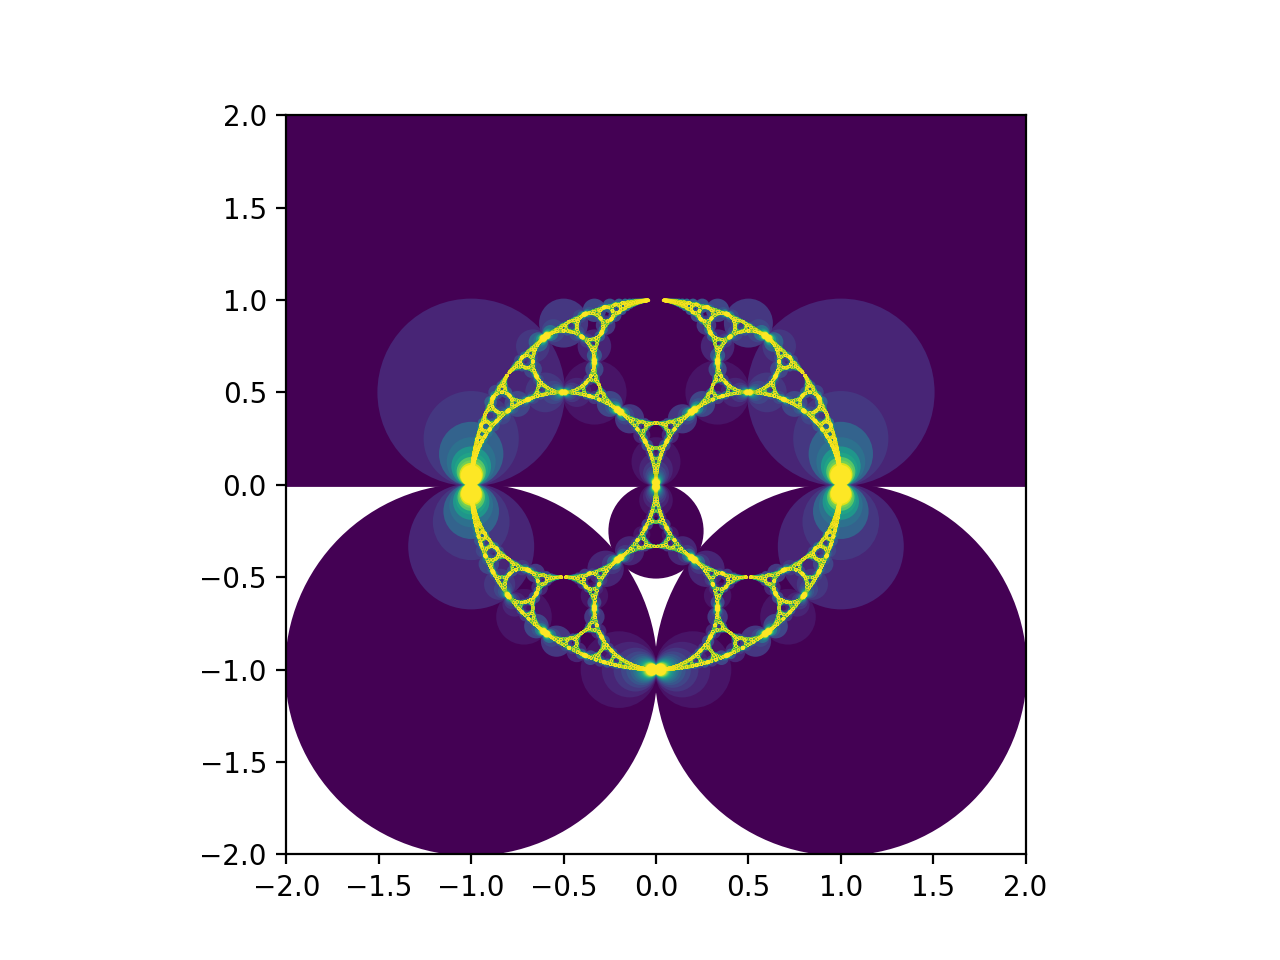

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

plot_tiles(gens, circs, plot_level=25, ax=ax)

<IPython.core.display.Javascript object>


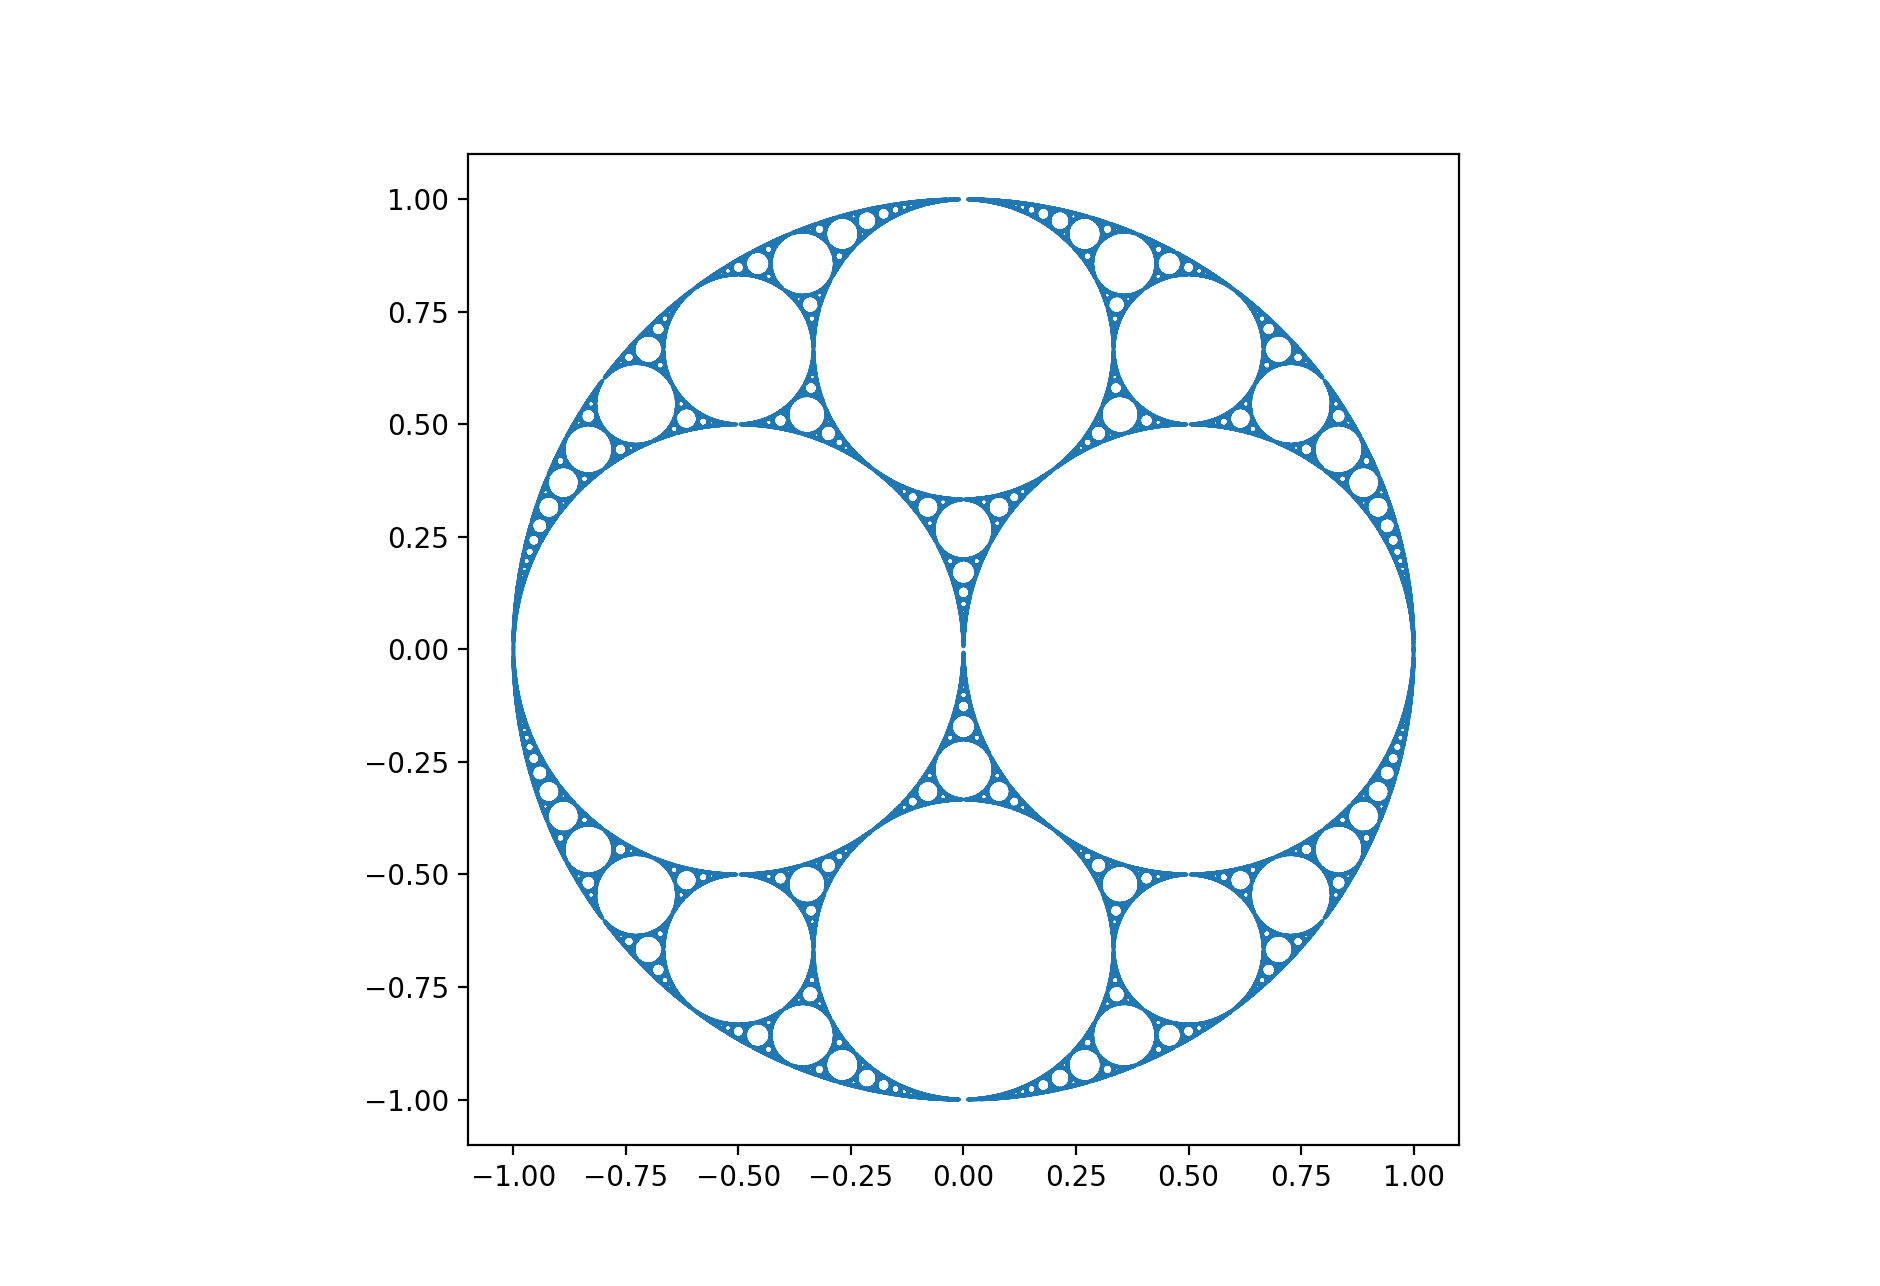

In [9]:
plot_limit_set(gens)